In questo esempio testo il mio modello InfoNCE che, invece di samplare in accordo a una data distribuzione di probabilità indotta dalle label, sampla uniformemente sul dataset e poi assegna una distanza tra due sample basata sulle loro label, con cui pesa i termini della InfoNCE.

In [1]:
%reload_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
from datasets import DatasetEEG, DatasetEEGTorch, TrialEEG
import torch
import numpy as np
from torch import nn

from sklearn.svm import SVC
from utils import plot_training_metrics, count_model_parameters, train_model
from dataset_filters import normalize_signals, crop_signals
from matplotlib import pyplot as plt

## Dataset sintetico single-label

In [2]:
trials_dummy = []
num_samples = 2000
data_dim = 64


# Genero i trial
for i in range(num_samples):
        
    label = np.random.randint(0,2)

    if label == 0:
        x = np.sin(np.linspace(0, 2 * np.pi, data_dim))
    else:
        x = np.cos(np.linspace(0, 2 * np.pi, data_dim))

    noise = np.random.randn(64)
    for k in range(4): 
        for l in range(1,data_dim-1):
            noise[l] = (noise[l] + noise[l-1] + noise[l+1])/3

    x += noise * 0.7

    x = x.reshape((data_dim, 1))
    x = x - np.mean(x)

    trial = TrialEEG(x, label, timepoints=np.linspace(0,1,data_dim))
    trials_dummy.append(trial)

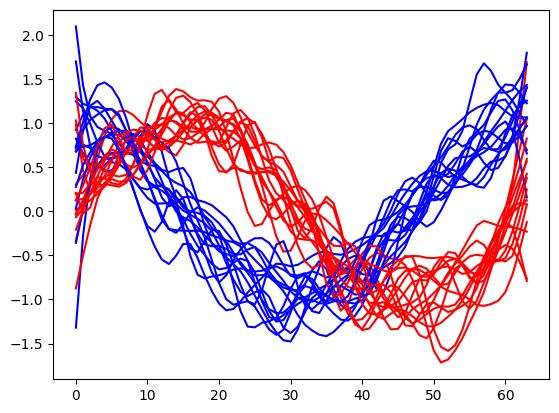

In [3]:
# Visualizzo qualche sample
plt.figure()
for i in range(0, 30):

    label = trials_dummy[i].label

    if label == 0: color = 'r'
    else: color = 'b'

    plt.plot(trials_dummy[i].eeg_signals, color=color)

In [3]:
dataset_dummy = DatasetEEG(trials_dummy)
print(dataset_dummy)


from datasets import DatasetEEGTorch
dataset_dummy_pytorch = DatasetEEGTorch(dataset_dummy)

# Se è presente la GPU sfrutto quella e sposto i dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

dataset_dummy_pytorch.to_device(device)



num_trials               :  2000
num_channels             :  64
num_timepoints           :  1
labels_type              :  single_label
labels_format            :  int

cuda


/home/nuzzi/Projects/EEG_Pipeline/EEG-ANN-Pipeline/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
from datasets import DataLoaderContrastive

dataloader = DataLoaderContrastive(dataset_dummy_pytorch, batch_size=32, batches_per_epoch=10)


In [5]:
# Ora creo il modello InfoNCE modificato con pesi e multilabel
from models.EncoderInfoNCE import EncoderContrastive

latent_dim = 3
num_channels = 22

# L'input è di tipo (batch_size, 1, num_channels, num_timepoints)
# Lo processo in maniera molto semplice facendo una convoluzione temporale
# e poi unendo i vari canali tra loro
layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(data_dim, 32),
        nn.LeakyReLU(),
        nn.BatchNorm1d(32),
        nn.Dropout(0.25),
        nn.Linear(32, 32),
        nn.LeakyReLU(),
        nn.BatchNorm1d(32),
        nn.Dropout(0.25),
        nn.Linear(32, latent_dim)
)


model = EncoderContrastive(layers=layers, temperature=0.1)
model.to(device)
print(f'Il modello ha {count_model_parameters(model)} parametri')

Il modello ha 3363 parametri


100%|██████████| 50/50 [00:07<00:00,  7.05it/s, alignement=0.000778, uniformity=0.0135, loss=0.0143]


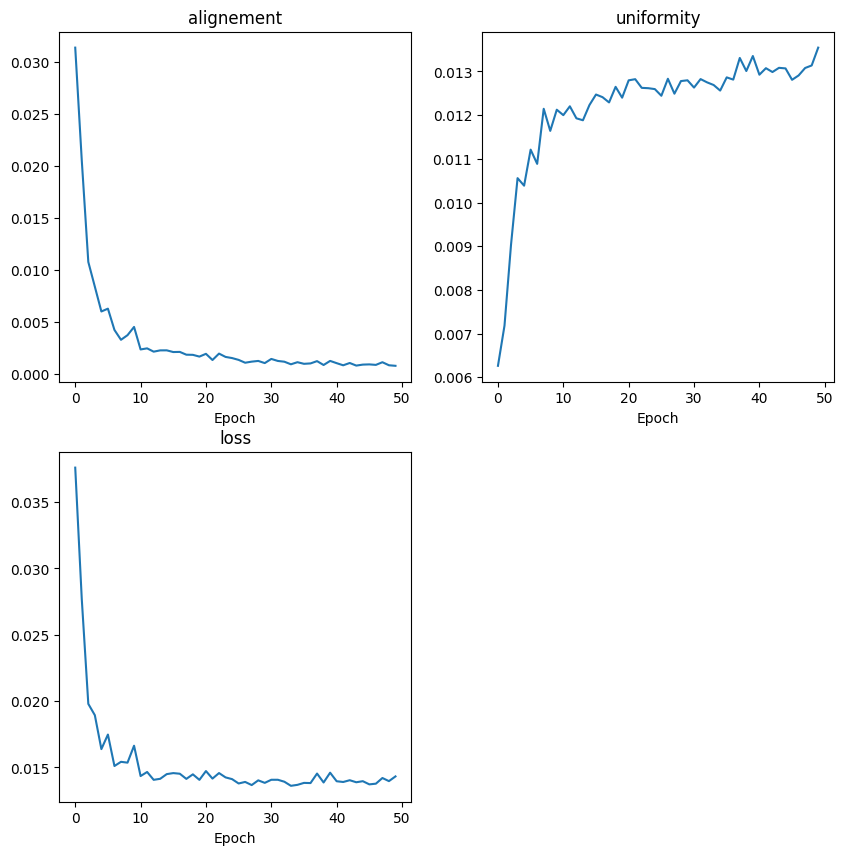

In [6]:
# Ottimizzatore
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Faccio il training e zottengo la storia di tutte le metriche
metrics = train_model(model, optimizer, dataloader, epochs=50)

# Plot risultati del training
plot_training_metrics(metrics)

In [14]:
from plots import plot_latents_3d
plot_latents_3d(encoded_train, labels_train)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [], 'layout': {'height': 500, 'template': '...', 'width': 500}
})

(-1.0, 1.0)

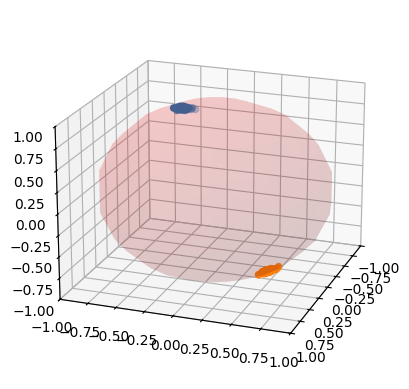

In [7]:
# Ottengo le rappresentazioni encoded del training set
model.eval()

encoded_train = np.zeros((0, latent_dim))
labels_train = np.zeros(0)

for batch in dataloader:

    x, _, _, labels = batch

    f_x = model.forward(x)
    
    encoded_train = np.concatenate((encoded_train, f_x.cpu().detach().numpy()), axis=0)
    labels_train = np.concatenate((labels_train, labels.cpu().detach().numpy()))

# Visualizzo, separandole per label
fig = plt.figure()
ax = fig.add_subplot(projection='3d', elev=20, azim=20)

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, color=[1,0,0,0.1])

for l in np.unique(labels_train):
    mask = labels_train == l
    ax.scatter(encoded_train[mask,0], encoded_train[mask,1], encoded_train[mask,2])

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)



Inizio creando un dataset d'esempio, in cui ci sono tre label differenti, entrambe a valori binari. La variabile "x" osservata viene presa come un vettore a 100 dimensioni ottenuto con delle manipolazioni non lineari delle due label e un po' di rumore

In [2]:
trials_dummy = []
num_samples = 2000
data_dim = 64

A = np.random.randn(64, 3)
B = np.random.randn(64)

# Smusso
for k in range(2):
    for i in range(data_dim):
        a = 0
        b = 0
        n = 0
        for j in range(-5,5):
            if i + j < data_dim and i + j >= 0:
                a += A[i+j,:]
                b += B[i+j]
                n += 1
        a /= n
        b /= n

        A[i,:] = a
        B[i] = b
        
for i in range(num_samples):

    label_1 = np.random.randint(0,2)
    label_2 = np.random.randint(0,2)
    label_3 = np.random.randint(0,2)

    x = A @ np.array([label_1, label_2, label_3]) + B
    x = x.reshape((data_dim, 1))
    x += np.random.randn(*x.shape) * 0.03
    x = x - np.mean(x)


    labels = {'label_1': label_1, 'label_2': label_2, 'label_3': label_3}

    
    trial = TrialEEG(x, labels, timepoints=np.linspace(0,1,data_dim))
    trials_dummy.append(trial)

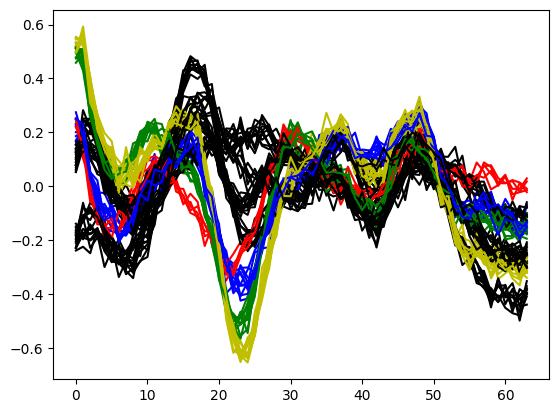

In [3]:
# Visualizzo qualche sample
plt.figure()
for i in range(80, 160):

    l1 = trials_dummy[i].label['label_1']
    l2 = trials_dummy[i].label['label_2']
    l3 = trials_dummy[i].label['label_3']

    color = 'k'

    if l1 == 1:
        if l2 == 0 and l3 == 0: color = 'r'
        if l2 == 0 and l3 == 1: color = 'b'
        if l2 == 1 and l3 == 0: color = 'g'
        if l2 == 1 and l3 == 1: color = 'y'

    plt.plot(trials_dummy[i].eeg_signals, color=color)

Creo effettivamente il dataset

In [8]:
dataset_dummy = DatasetEEG(trials_dummy)
print(dataset_dummy)

num_trials               :  2000
num_channels             :  64
num_timepoints           :  1
labels_type              :  multi_label
labels_format            :  {'label_1': 'int', 'label_2': 'int', 'label_3': 'int'}



In [10]:
from datasets import DatasetEEGTorch

dataset_dummy_pytorch = DatasetEEGTorch(dataset_dummy)

# Se è presente la GPU sfrutto quella e sposto i dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

dataset_dummy_pytorch.to_device(device)


cuda


In [35]:
from datasets import DataLoaderContrastive

dataloader = DataLoaderContrastive(dataset_dummy_pytorch, batch_size=32, batches_per_epoch=10)


for batch in dataloader:

    print(batch[0].shape)

torch.Size([32, 1, 64, 1])
torch.Size([32, 1, 64, 1])
torch.Size([32, 1, 64, 1])
torch.Size([32, 1, 64, 1])
torch.Size([32, 1, 64, 1])
torch.Size([32, 1, 64, 1])
torch.Size([32, 1, 64, 1])
torch.Size([32, 1, 64, 1])
torch.Size([32, 1, 64, 1])
torch.Size([32, 1, 64, 1])


In [355]:
# Definisco la distance function
def labels_distance_function(label, other_labels):

    # Devo produrre un tensore di distanze 
    N_trials = len(other_labels['label_1'])
    
    distances = torch.zeros((N_trials, 3))

    distances[:,0] = (label['label_1'] == other_labels['label_1']) * 1
    distances[:,1] = (label['label_2'] == other_labels['label_2']) * 1
    distances[:,2] = (label['label_3'] == other_labels['label_3']) * 1

    return distances

Creo i dataset e dataloader

In [356]:
# Creo il dataset ma specifico per questo tipo di InfoNCE, che calcoli le distanze tra label all'inizio
from datasets import DatasetEEGTorchInfoNCE

dataset_dummy_pytorch = DatasetEEGTorchInfoNCE(dataset_dummy, labels_distance_function)

# Se è presente la GPU sfrutto quella e sposto i dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

dataset_dummy_pytorch.to_device(device)

# Creo i dataloader
batch_size = 64
dataloader_training = DataLoader(dataset_dummy_pytorch, batch_size=batch_size, shuffle=True)


cuda


In [357]:
# Ora creo il modello InfoNCE modificato con pesi e multilabel
from models.EncoderInfoNCE import EncoderInfoNCEW

latent_dim = 3
num_channels = 22

# L'input è di tipo (batch_size, 1, num_channels, num_timepoints)
# Lo processo in maniera molto semplice facendo una convoluzione temporale
# e poi unendo i vari canali tra loro
layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(data_dim, 32),
        nn.LeakyReLU(),
        nn.BatchNorm1d(32),
        nn.Dropout(0.25),
        nn.Linear(32, 32),
        nn.LeakyReLU(),
        nn.BatchNorm1d(32),
        nn.Dropout(0.25),
        nn.Linear(32, latent_dim)
)


model = EncoderInfoNCEW(layers=layers, temperature=0.1, label_weights=dataset_dummy_pytorch.label_weights)
model.to(device)
print(f'Il modello ha {count_model_parameters(model)} parametri')

Il modello ha 3363 parametri


In [358]:
# Ottimizzatore
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Faccio il training e zottengo la storia di tutte le metriche
metrics = train_model(model, optimizer, dataloader_training, epochs=50)

# Plot risultati del training
plot_training_metrics(metrics)

 12%|█▏        | 6/50 [00:01<00:13,  3.33it/s, loss=-19.7]


KeyboardInterrupt: 

(-1.0, 1.0)

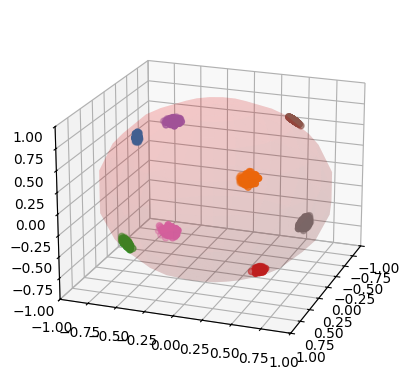

In [311]:
# Ottengo le rappresentazioni encoded del training set
model.eval()

encoded_train = np.zeros((0, latent_dim))
labels_train = np.zeros(0)

for batch in dataloader_training:

    x, labels, _ = batch

    # Unisco in un'unica label
    label = labels['label_1'] + labels['label_2'] * 2 + labels['label_3'] * 4

    f_x = model.forward(x)
    
    encoded_train = np.concatenate((encoded_train, f_x.cpu().detach().numpy()), axis=0)
    labels_train = np.concatenate((labels_train, label.cpu().detach().numpy()))

# Visualizzo, separandole per label
fig = plt.figure()
ax = fig.add_subplot(projection='3d', elev=20, azim=20)

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, color=[1,0,0,0.1])

for l in np.unique(labels_train):
    mask = labels_train == l
    ax.scatter(encoded_train[mask,0], encoded_train[mask,1], encoded_train[mask,2])

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)



Per ora creo a mano il dataset BCI multi-label con le seguenti caratteristiche:
- Ogni sample sono 10 punti (quindi 10/250 = 1/25 s).
- Lo shift tra finestre lo faccio di 10 punti in modo che non ci sia una sovrapposizione tra samples
- A ogni sample assegno tre label differenti:
1) Classe dello stimolo (da 0 a 4, dove 4 = nessuna, 0-3 quelle dei dati)
2) Condizione, 0 = fixation cross, 1 = cue, 2 = motor imagery
3) Distanza temporale dall'inizio della cue (quindi lo 0 dei tempi)

Tutte le label vengono misurate a partire dall'elemento centrale della finestra



In [2]:
dataset = DatasetEEG.load('DatasetBCI/Dataset_03_Training_NoArtifacts.dataset')
normalize_signals(dataset)

# Lo shift è dato in punti, mentre tutti gli altri parametri
# sono dati come tempi in secondi
fs = 250
dt = 1/fs
shift = 5       # Shift temporale (in punti) tra finestre
window = 250      # Larghezza (in punti) della finestra

trials_new = []

# Ciclo sui trial
for n, trial in enumerate(dataset.trials):

    signals = trial.eeg_signals
    label = trial.label
    times = trial.timepoints
    
    # Creo la prima finestra
    ind_center = window // 2
    ind_min = ind_center - window // 2
    ind_max = ind_min + window

    # Ciclo fino a quando non ho finito lo spazio nel trial
    while ind_max < len(times):

        t = times[ind_max]
        
        # In base a "t" devo capire in che condizione mi trovo
        if t >= -2 and t < 0:
            condition = 'Fixation'
            label_cue = 4
        elif t >= 0 and t < 1:
            condition = 'Cue'
            label_cue = label
        elif t >= 1 and t < 4:
            condition = 'Imagery'
            label_cue = label
        else:
            condition = None

        # Se sono in una condizione accettabile costruisco il sample
        if condition is not None:
            x = signals[:, ind_min:ind_max]
            label_full = {'Cue': label_cue, 'Time': t, 'Condition': condition}
            trial_new = TrialEEG(x, label_full, times[ind_min:ind_max])
            trials_new.append(trial_new)

        ind_center += shift
        ind_min = ind_center - window // 2
        ind_max = ind_min + window



In [3]:
dataset_windows = DatasetEEG(trials_new, info=dataset.info)
print(dataset_windows)


num_trials               :  67500
num_channels             :  22
num_timepoints           :  250
labels_type              :  multi_label
labels_format            :  {'Cue': 'int', 'Time': 'float', 'Condition': 'string'}
subject                  :  3
fs                       :  250



In [5]:

def labels_distance_function(label, other_labels):

    # Devo produrre un tensore di distanze 
    N_trials = len(other_labels['Cue'])
    
    distances = torch.zeros((N_trials, 3))

    # Cue
    distances[:,0] = (label['Cue'] == other_labels['Cue']) * 1
    # Time
    distances[:,1] = torch.exp(-4 * (label['Time'] - other_labels['Time'])**2 )
    # Condition
    distances[:,2] = (label['Condition'] == other_labels['Condition']) * 1

    # distances[:,1] = 1 # Per eliminare una label dalla loss
    # distances[:,2] = 1

    return distances

In [9]:
# Creo il dataset ma specifico per questo tipo di InfoNCE, che calcoli le distanze tra label all'inizio
from datasets import DatasetEEGTorchInfoNCE

dataset_training_pytorch = DatasetEEGTorchInfoNCE(dataset_windows, None)

# Se è presente la GPU sfrutto quella e sposto i dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

dataset_training_pytorch.to_device(device)

# Creo i dataloader
batch_size = 256
dataloader_training = DataLoader(dataset_training_pytorch, batch_size=batch_size, shuffle=True)


cuda


In [10]:
# Ora creo il modello InfoNCE modificato con pesi e multilabel
from models.EncoderInfoNCE import EncoderInfoNCEW

latent_dim = 3
num_channels = 22
F1, F2 = 16, 32

# L'input è di tipo (batch_size, 1, num_channels, num_timepoints)
# Lo processo in maniera molto semplice facendo una convoluzione temporale
# e poi unendo i vari canali tra loro
layers =  nn.Sequential(
            nn.Conv2d(1, F1, kernel_size=(1, 64), padding='same', bias=False), # First temporal convolution
            nn.BatchNorm2d(F1),
            nn.Conv2d(F1, F2, kernel_size=(num_channels, 1), bias=False, groups=F1), # Depthwise convolution
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1,4)),
            nn.Dropout(0.5),
            nn.Conv2d(F2, F2, kernel_size=(1, 16), bias=False, groups=F2),  # Separable = Depthwise + Pointwise
            nn.Conv2d(F2, F2, kernel_size=(1, 1), bias=False),              # Separable = Depthwise + Pointwise
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1,8)),
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.LazyLinear(latent_dim)
        )


model = EncoderInfoNCEW(layers=layers, temperature=1, train_temperature=False, label_weights=labels_distance_function)
model.to(device)
print(f'Il modello ha {count_model_parameters(model)} parametri')

Il modello ha 3424 parametri


In [13]:
# Ottimizzatore
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Faccio il training e zottengo la storia di tutte le metriche
metrics = train_model(model, optimizer, dataloader_training, epochs=1000)

# Plot risultati del training
plot_training_metrics(metrics)

  0%|          | 0/1000 [00:00<?, ?it/s]

 14%|█▎        | 136/1000 [37:12<3:49:17, 15.92s/it, loss=3.13]

In [50]:
import pickle as pkl
with open('saved_models/InfoNCEW_ThreeLabels.pkl','wb') as f:
    pkl.dump(model, f)

{'Condition': {0: 'Fixation', 1: 'Cue', 2: 'Imagery'}}


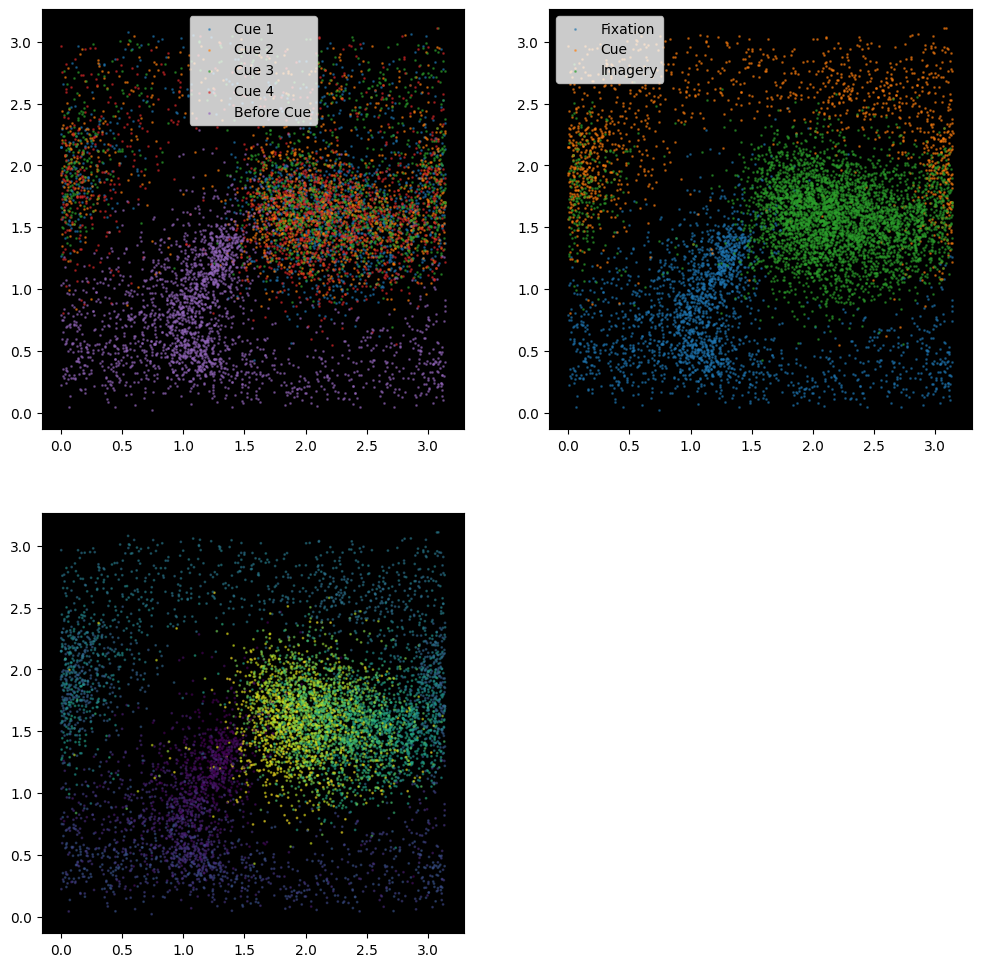

In [51]:
# Ottengo le rappresentazioni encoded del training set
model.eval()

encoded_train = np.zeros((0, latent_dim))
labels_train_cue = np.zeros(0)
labels_train_condition = np.zeros(0)
labels_train_time = np.zeros(0)

for batch in dataloader_training:

    x, labels, _ = batch
    f_x = model.forward(x)
    
    encoded_train = np.concatenate((encoded_train, f_x.cpu().detach().numpy()), axis=0)
    labels_train_cue = np.concatenate((labels_train_cue, labels['Cue'].cpu().detach().numpy()))
    labels_train_time = np.concatenate((labels_train_time, labels['Time'].cpu().detach().numpy()))
    labels_train_condition = np.concatenate((labels_train_condition, labels['Condition'].cpu().detach().numpy()))

# Visualizzo i dati, sul piano, separandoli per label
# Proietto sul piano UV
x, y, z = encoded_train[:,0], encoded_train[:,1], encoded_train[:,2]
v = np.arccos(z)
u = np.arctan2(y,x)

# Correggo l'angolo
u[u < 0] += np.pi

plt.figure(figsize=(12,12))

# Separati per CUE
plt.subplot(2,2,1)
for l in np.unique(labels_train_cue):
    mask = labels_train_cue == l
    plt.scatter(u[mask], v[mask], 1, alpha=0.5)

plt.legend(['Cue 1','Cue 2','Cue 3','Cue 4','Before Cue'])
plt.gca().set_facecolor('k')

# Separati per Condition
plt.subplot(2,2,2)
for l in np.unique(labels_train_condition):
    mask = labels_train_condition == l
    plt.scatter(u[mask], v[mask], 1, alpha=0.5)

print(dataset_training_pytorch.labels_int_to_str)
plt.legend(['Fixation','Cue','Imagery'])
plt.gca().set_facecolor('k')

# Tempo
plt.subplot(2,2,3)
t = labels_train_time
t = (t - np.min(t)) / (np.max(t) - np.min(t))
colors = plt.cm.viridis(t)
plt.scatter(u, v, 1, colors, alpha=0.5)
plt.gca().set_facecolor('k')


In [37]:
# Inizializzo il modello SVC
from sklearn.svm import SVC

model_svc = SVC()

# Fit del modello e calcolo accuratezza
model_svc.fit(encoded_train, labels_train_cue)
accuracy = model_svc.score(encoded_train, labels_train_cue)

print(f'Training accuracy for CUE = {accuracy*100:.2f}%')

model_svc.fit(encoded_train, labels_train_condition)
accuracy = model_svc.score(encoded_train, labels_train_condition)

print(f'Training accuracy for CONDITION = {accuracy*100:.2f}%')

Training accuracy for CUE = 50.52%
Training accuracy for CONDITION = 97.59%


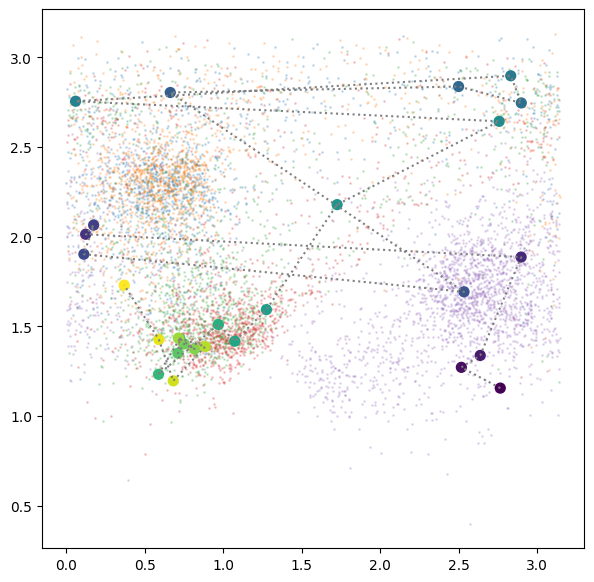

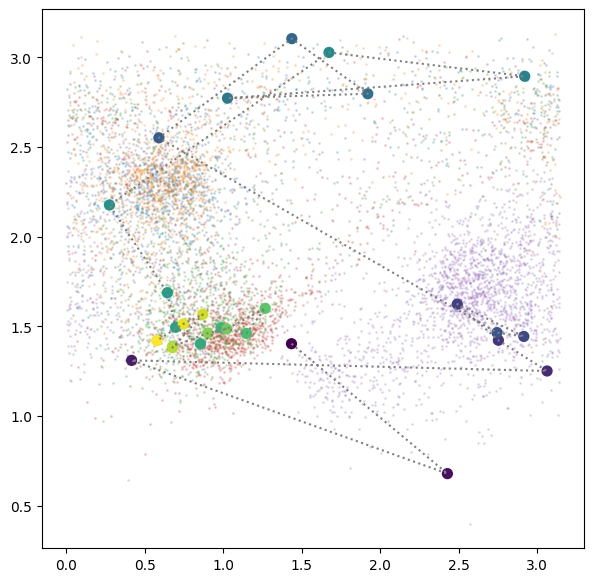

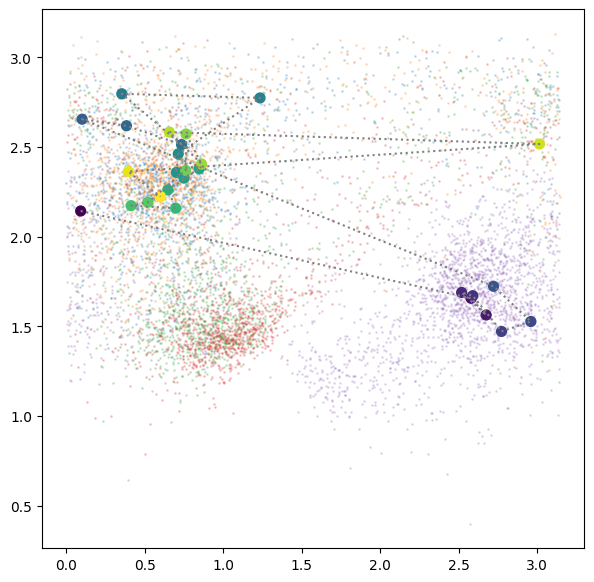

In [557]:
# Ripeto per un singolo trial, per vedere come vengono codificati
model.eval()

for n in range(3):

    plt.figure(figsize=(7,7))

    encoded = np.zeros((0, latent_dim))
    labels = np.zeros(0)

    for i in range(n*28,(n+1)*28):
        x, l, _ = dataset_training_pytorch[i]
        x = x.view((1,1,22,-1))
        f_x = model.forward(x)
        
        encoded = np.concatenate((encoded, f_x.cpu().detach().numpy()), axis=0)
        labels = np.concatenate((labels, l['Time'].view((1)).cpu().detach().numpy()))
 
    delta = 0

    # Separati per CUE
    for l in np.unique(labels_train_cue):
        mask = labels_train_cue == l
        plt.scatter(u[mask] + delta, v[mask], 1, alpha=0.2)

    # Visualizzo i dati, sul piano, separandoli per label
    # Proietto sul piano UV
    x, y, z = encoded[:,0], encoded[:,1], encoded[:,2]
    v1 = np.arccos(z)
    u1 = np.arctan2(y,x)

    u1[u1 < 0] += np.pi


    t = labels
    t = (t - np.min(t)) / (np.max(t) - np.min(t))
    colors = plt.cm.viridis(t)
        
    plt.scatter(u1 + delta, v1, 50, colors)
    plt.plot(u1 + delta, v1, ':', color='grey')



Visualizzo, come fa CEBRA, anche le traiettorie per tutti i trial, colorando i punti in base al tempo

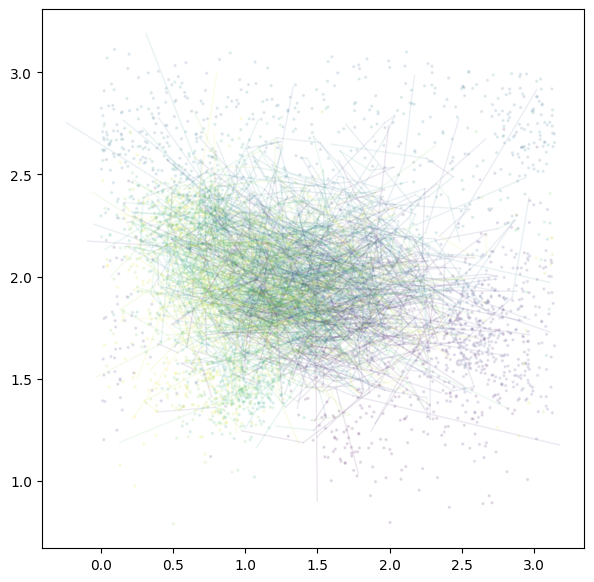

In [580]:
from scipy.signal import savgol_filter

model.eval()


t = labels_train_time
t = (t - np.min(t)) / (np.max(t) - np.min(t))
colors = plt.cm.viridis(t)

plt.figure(figsize=(7,7))

for n in range(100):

    ind_min = n*28
    ind_max = (n+1)*28

    u_n = u[ind_min:ind_max]
    v_n = v[ind_min:ind_max]
    c = colors[ind_min:ind_max]

    plt.scatter(u_n, v_n, 2, c, alpha=0.1)

    # Linee
    for i in range(27):
        u_smooth = savgol_filter(u_n, 10, 3)
        v_smooth =  savgol_filter(v_n, 10, 3)
        plt.plot([u_smooth[i], u_smooth[i+1]], [v_smooth[i], v_smooth[i+1]], color=c[i], linewidth=1, alpha=0.1)


    # # Separati per CUE
    # for l in np.unique(labels_train_cue):
    #     mask = labels_train_cue == l
    #     plt.scatter(u[mask] + delta, v[mask], 1, alpha=0.2)

    # # Visualizzo i dati, sul piano, separandoli per label
    # # Proietto sul piano UV
    # x, y, z = encoded[:,0], encoded[:,1], encoded[:,2]
    # v1 = np.arccos(z)
    # u1 = np.arctan2(y,x)

    # u1[u1 < 0] += np.pi


    # t = labels
    # t = (t - np.min(t)) / (np.max(t) - np.min(t))
    # colors = plt.cm.viridis(t)
        
    # plt.scatter(u1 + delta, v1, 50, colors)
    # plt.plot(u1 + delta, v1, ':', color='grey')



Ripeto tutto, ma con delle finestre molto più piccole e con tantissimi trial

In [2]:
dataset = DatasetEEG.load('DatasetBCI/Dataset_01_Training_NoArtifacts.dataset')
normalize_signals(dataset)

# Lo shift è dato in punti, mentre tutti gli altri parametri
# sono dati come tempi in secondi
fs = 250
dt = 1/fs
shift = 10       # Shift temporale (in punti) tra finestre
window = 30      # Larghezza (in punti) della finestra

trials_new = []

# Ciclo sui trial
for n, trial in enumerate(dataset.trials):

    signals = trial.eeg_signals
    label = trial.label
    times = trial.timepoints
    
    # Creo la prima finestra
    ind_center = window // 2
    ind_min = ind_center - window // 2
    ind_max = ind_min + window

    # Ciclo fino a quando non ho finito lo spazio nel trial
    while ind_max < len(times):

        t = times[ind_center]
        
        # In base a "t" devo capire in che condizione mi trovo
        if t >= -2 and t < 0:
            condition = 'Fixation'
            label_cue = 4
        elif t >= 0 and t < 1:
            condition = 'Cue'
            label_cue = label
        elif t >= 1 and t < 4:
            condition = 'Imagery'
            label_cue = label
        else:
            condition = None

        # Se sono in una condizione accettabile costruisco il sample
        if condition is not None:
            x = signals[:, ind_min:ind_max]
            label_full = {'Cue': label_cue, 'Time': t, 'Condition': condition}
            trial_new = TrialEEG(x, label_full, times[ind_min:ind_max])
            trials_new.append(trial_new)

        ind_center += shift
        ind_min = ind_center - window // 2
        ind_max = ind_min + window



In [3]:
dataset_windows = DatasetEEG(trials_new, info=dataset.info)
print(dataset_windows)


num_trials               :  40528
num_channels             :  22
num_timepoints           :  30
labels_type              :  multi_label
labels_format            :  {'Cue': 'int', 'Time': 'float', 'Condition': 'string'}
subject                  :  1
fs                       :  250



In [4]:

def labels_distance_function(label, other_labels):

    # Devo produrre un tensore di distanze 
    N_trials = len(other_labels['Cue'])
    
    distances = torch.zeros((N_trials, 3))

    # Cue
    distances[:,0] = (label['Cue'] == other_labels['Cue']) * 1
    # Time
    distances[:,1] = torch.exp(-3 * (label['Time'] - other_labels['Time'])**2 )
    # Condition
    distances[:,2] = (label['Condition'] == other_labels['Condition']) * 1

    # distances[:,1] = 1 # Per eliminare una label dalla loss
    # distances[:,2] = 1

    return distances

In [15]:
# Creo il dataset ma specifico per questo tipo di InfoNCE, che calcoli le distanze tra label all'inizio
from datasets import DatasetEEGTorchInfoNCE

dataset_training_pytorch = DatasetEEGTorchInfoNCE(dataset_windows, labels_distance_function)

# Se è presente la GPU sfrutto quella e sposto i dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

dataset_training_pytorch.to_device(device)

# Creo i dataloader
batch_size = 256
dataloader_training = DataLoader(dataset_training_pytorch, batch_size=batch_size, shuffle=True)


cuda


In [16]:
# Ora creo il modello InfoNCE modificato con pesi e multilabel
from models.EncoderInfoNCE import EncoderInfoNCEW

latent_dim = 3
num_channels = 22
F1, F2 = 16, 32

# L'input è di tipo (batch_size, 1, num_channels, num_timepoints)
# Lo processo in maniera molto semplice facendo una convoluzione temporale
# e poi unendo i vari canali tra loro
layers =  nn.Sequential(
            nn.Conv2d(1, F1, kernel_size=(1, 64), padding='same', bias=False), # First temporal convolution
            nn.BatchNorm2d(F1),
            nn.Conv2d(F1, F2, kernel_size=(num_channels, 1), bias=False, groups=F1), # Depthwise convolution
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Conv2d(F2, F2, kernel_size=(1, 8), bias=False, groups=F2),  # Separable = Depthwise + Pointwise
            nn.Conv2d(F2, F2, kernel_size=(1, 1), bias=False),              # Separable = Depthwise + Pointwise
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.LazyLinear(latent_dim)
        )


model = EncoderInfoNCEW(layers=layers, temperature=0.1, train_temperature=True, label_weights=dataset_training_pytorch.label_weights)
model.to(device)
print(f'Il modello ha {count_model_parameters(model)} parametri')

Il modello ha 3169 parametri


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [37:33<00:00,  2.25s/it, loss=3.92]


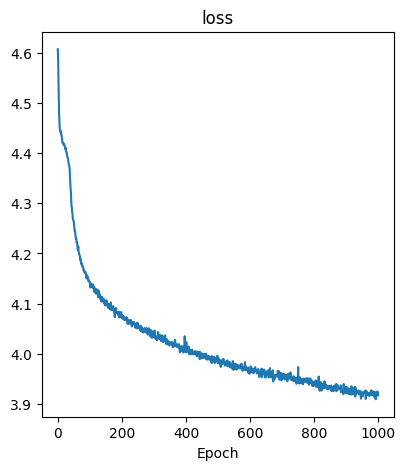

In [17]:

# Ottimizzatore
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Faccio il training e zottengo la storia di tutte le metriche
metrics = train_model(model, optimizer, dataloader_training, epochs=1000)

# Plot risultati del training
plot_training_metrics(metrics)

{'Condition': {0: 'Fixation', 1: 'Cue', 2: 'Imagery'}}


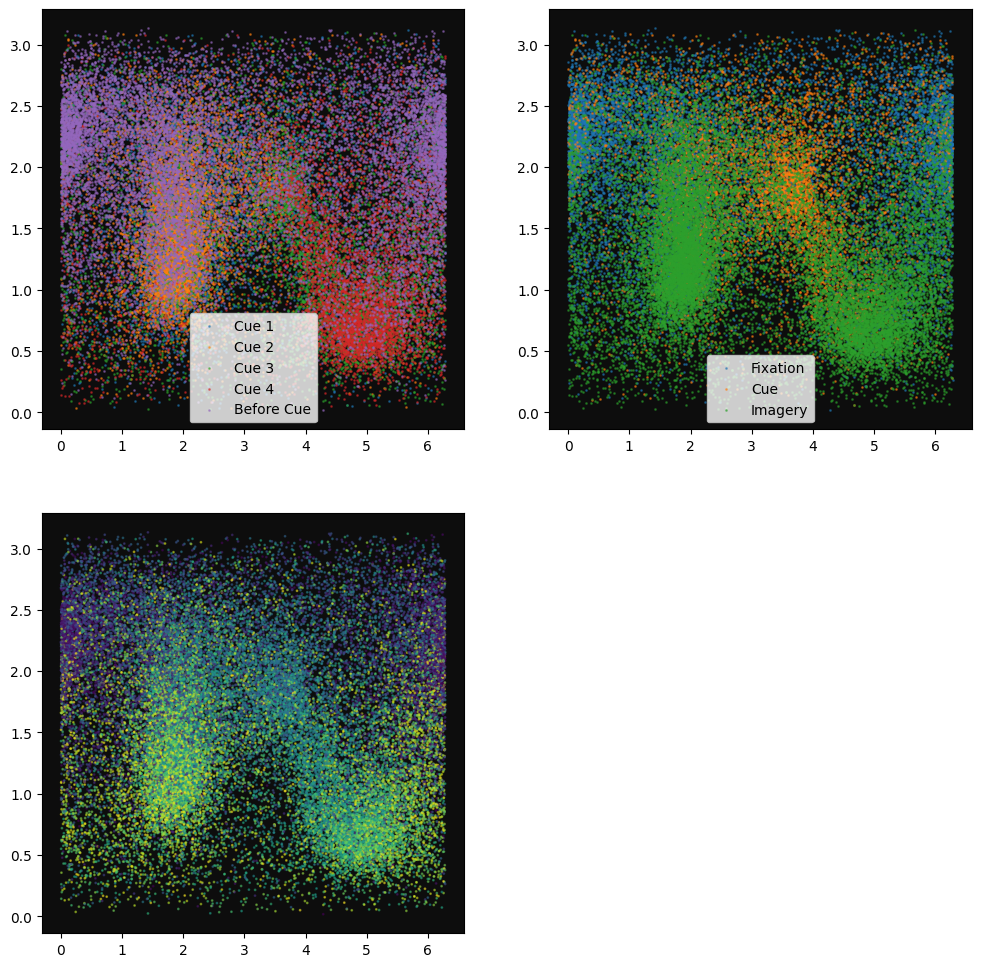

In [24]:
# Ottengo le rappresentazioni encoded del training set
model.eval()

encoded_train = np.zeros((0, latent_dim))
labels_train_cue = np.zeros(0)
labels_train_condition = np.zeros(0)
labels_train_time = np.zeros(0)

for batch in dataloader_training:

    x, labels, _ = batch
    f_x = model.forward(x)
    
    encoded_train = np.concatenate((encoded_train, f_x.cpu().detach().numpy()), axis=0)
    labels_train_cue = np.concatenate((labels_train_cue, labels['Cue'].cpu().detach().numpy()))
    labels_train_time = np.concatenate((labels_train_time, labels['Time'].cpu().detach().numpy()))
    labels_train_condition = np.concatenate((labels_train_condition, labels['Condition'].cpu().detach().numpy()))

# Visualizzo i dati, sul piano, separandoli per label
# Proietto sul piano UV
x, y, z = encoded_train[:,0], encoded_train[:,1], encoded_train[:,2]
v = np.arccos(z)
u = np.arctan2(y,x)

# Correggo l'angolo
u[u < 0] += 2 * np.pi

plt.figure(figsize=(12,12))
# Separati per CUE
plt.subplot(2,2,1)
cue_centers = []
for l in np.unique(labels_train_cue):
    mask = labels_train_cue == l
    plt.scatter(u[mask], v[mask], 1, alpha=0.5)

plt.legend(['Cue 1','Cue 2','Cue 3','Cue 4','Before Cue'])
plt.gca().set_facecolor([0.05,0.05,0.05])

# Separati per Condition
plt.subplot(2,2,2)
for l in np.unique(labels_train_condition):
    mask = labels_train_condition == l
    plt.scatter(u[mask], v[mask], 1, alpha=0.5)

print(dataset_training_pytorch.labels_int_to_str)
plt.legend(['Fixation','Cue','Imagery'])
plt.gca().set_facecolor([0.05,0.05,0.05])

# Tempo
plt.subplot(2,2,3)
t = labels_train_time
t = (t - np.min(t)) / (np.max(t) - np.min(t))
colors = plt.cm.viridis(t)
plt.scatter(u, v, 1, colors, alpha=0.5)

plt.gca().set_facecolor([0.05,0.05,0.05])